# Import libs

In [2]:
!pip install -q -U watermark
!pip install -qq transformers
!pip install seaborn

     |████████████████████████████████| 1.3MB 4.7MB/s 
     |████████████████████████████████| 2.9MB 29.7MB/s 
     |████████████████████████████████| 1.1MB 50.9MB/s 
     |████████████████████████████████| 890kB 47.5MB/s 


In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.2
torch 1.6.0+cu101
transformers 3.4.0


In [4]:
import os
import re
import tqdm as tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
!nvidia-smi

Sat Oct 24 05:05:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!pwd

/content


In [7]:
cd /content/drive/My Drive/Colab Notebooks/SSTdata

/content/drive/My Drive/Colab Notebooks/SSTdata


#Import Train set



In [8]:
train = pd.read_csv('sst_train.tsv', sep='\t', header=None, names=['truth', 'sentence'])
train['truth'] = train['truth'].astype('category').str.replace("__label__",'')
train['truth'] = train['truth'].astype(int) - 1
train['truth'] = train['truth'].astype('category')

In [9]:
train.head()

,truth,sentence
0,3,The Rock is destined to be the 21st Century 's...
1,4,The gorgeously elaborate continuation of `` Th...
2,3,Singer/composer Bryan Adams contributes a slew...
3,2,You 'd think by now America would have had eno...
4,3,Yet the act is still charming here .


# Import validation set

In [10]:
val = pd.read_csv('sst_dev.tsv', sep='\t', header = None, names=['truth', 'sentence'])
val['truth'] = val['truth'].str.replace("__label__", '')
val['truth'] = val['truth'].astype(int) - 1
val['truth'] = val['truth'].astype('category')

In [11]:
val.head(5)

,truth,sentence
0,3,It 's a lovely film with lovely performances b...
1,2,"No one goes unindicted here , which is probabl..."
2,3,And if you 're not nearly moved to tears by a ...
3,4,"A warm , funny , engaging film ."
4,4,Uses sharp humor and insight into human nature...


#Import Test set

In [12]:
test = pd.read_csv('sst_test.tsv', sep='\t', header = None, names=['truth', 'sentence'])
test['truth'] = test['truth'].str.replace("__label__", '')
test['truth'] = test['truth'].astype(int) - 1
test['truth'] = test['truth'].astype('category')

In [13]:
test.head()

,truth,sentence
0,2,Effective but too-tepid biopic
1,3,If you sometimes like to go to the movies to h...
2,4,"Emerges as something rare , an issue movie tha..."
3,2,The film provides some great insight into the ...
4,4,Offers that rare combination of entertainment ...


#Check train val test sizes

In [14]:
df = pd.concat([train, val, test])

In [15]:
print(f"Train size = {len(train)}")
print(f"Val size   = {len(val)}")
print(f"Test size  = {len(test)}")
print(f"Data size  = {len(df)}")

Train size = 8544
Val size   = 1101
Test size  = 2210
Data size  = 11855


#Check class distribution

In [16]:
!pip install pygal
!pip install cairosvg
import pygal
import cairosvg


     |████████████████████████████████| 133kB 5.0MB/s 
     |████████████████████████████████| 51kB 2.7MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.1.0-cp36-none-any.whl size=88591 sha256=319498a26ccbaade06da6fe51eff1c5b5702c37e5de58e3029b403c283bcd459
  Stored in directory: /root/.cache/pip/wheels/11/5e/47/167d9dfd5fa5850dd0cd3db80afe6db46e620edec3419dce5a
Successfully built cairocffi


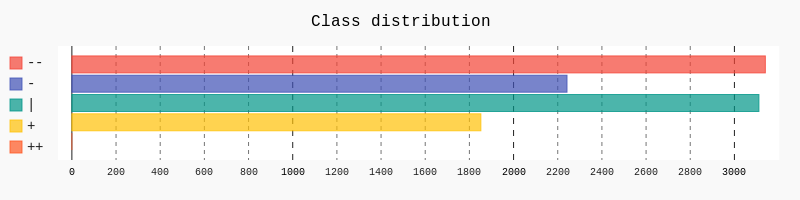

In [17]:
very_negative = len(df[df['truth']==1])
negative = len(df[df['truth']==2])
neutral = len(df[df['truth']==3])
positive = len(df[df['truth']==4])
very_positive = len(df[df['truth']==5])

chart = pygal.HorizontalBar(height=200)
chart.title = 'Class distribution'
chart.add('--', very_negative)
chart.add('-', negative)
chart.add('|', neutral)
chart.add('+', positive)
chart.add('++', very_positive)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'classes')

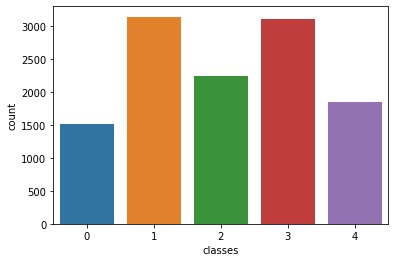

In [18]:
import seaborn as sns
sns.countplot(df.truth)
plt.xlabel('classes')

In [19]:
class_names = df['truth'].unique()
class_names

[3, 4, 2, 1, 0]
Categories (5, int64): [3, 4, 2, 1, 0]

##BERT Tokenizer

In [20]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [21]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [22]:
sample_text = "Hi. I am Sakshi. I am testing the BERT Tokenizer"
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens=tokens)

print(f"Sentence  : {sample_text}")
print(f"Tokens    : {tokens}")
print(f"Token ids : {token_ids}")

Sentence  : Hi. I am Sakshi. I am testing the BERT Tokenizer
Tokens    : ['hi', '.', 'i', 'am', 'sa', '##kshi', '.', 'i', 'am', 'testing', 'the', 'bert', 'token', '##izer']
Token ids : [7632, 1012, 1045, 2572, 7842, 27488, 1012, 1045, 2572, 5604, 1996, 14324, 19204, 17629]


##Special tokens

[SEP] - end of sentence marker

In [23]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

[CLS] - add before every sentence so that the model knows we are classifying

In [24]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

[PAD] - tokens for padding

In [25]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

[UNK] - tokens for unknown words

In [26]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [27]:
encoding = tokenizer.encode_plus(sample_text,
                                 max_length = 32,
                                 add_special_tokens=True,
                                 return_token_type_ids=False,
                                 padding='max_length',
                                 return_attention_mask=True,
                                 return_tensors='pt')
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [28]:
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print()
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'][0])

32
tensor([  101,  7632,  1012,  1045,  2572,  7842, 27488,  1012,  1045,  2572,
         5604,  1996, 14324, 19204, 17629,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

32
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


#Choosing Sequence Length

In [29]:
token_lens = []
i=0

for txt in df.sentence:
  tokens = tokenizer.encode(txt, max_length = 512, truncation=True)
  token_lens.append(len(tokens))
  # if i>5:
  #   break
  # i+=1

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

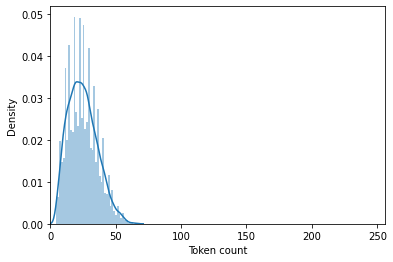

In [30]:
sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

#DataLoader

In [31]:
import torch
from torch.utils.data import Dataset, DataLoader

class SSTDataset(Dataset):
  def __init__(self, sentences, targets, tokenizer, max_len):
    self.sentences = sentences
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.sentences)

  def __getitem__(self, item):
    sentence = str(self.sentences[item])
    target = self.targets[item]

    encoding = tokenizer.encode_plus(sentence,
                                 max_length = self.max_len,
                                 add_special_tokens=True,
                                 return_token_type_ids=False,
                                 padding='max_length',
                                 truncation=True,
                                 return_attention_mask=True,
                                 return_tensors='pt')
    
    return{
        'sentence' : sentence,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(target, dtype = torch.long)
    }

In [32]:
def create_dataloader(df, tokenizer, max_len, batch_size):
  ds = SSTDataset(
      sentences=df.sentence.to_numpy(),
      targets=df.truth.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4
  )

In [33]:
BATCH_SIZE = 16
MAX_LEN = 128

In [34]:
train_dataloader = create_dataloader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = create_dataloader(val, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = create_dataloader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [35]:
data = next(iter(train_dataloader))
print(data.keys())

print()

data = next(iter(val_dataloader))
print(data.keys())

print()

data = next(iter(test_dataloader))
print(data.keys())

dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])

dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])

dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])


#Sentiment Classification with BERT and HuggingFace

In [36]:
from transformers import BertModel
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [37]:
#testing bert_model on sample example
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)

In [38]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [39]:
bert_model.config.hidden_size

768

In [40]:
pooled_output.shape

torch.Size([1, 768])

In [46]:
from torch import nn

class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME).config
    self.drop = nn.Dropout(p=0.3)
    #self.relu = nn.ReLU()
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )

    output = self.drop(pooled_output)
    #output = self.relu(output)
    return self.out(output)

In [47]:
# !export CUDA_LAUNCH_BLOCKING=1;
torch.cuda.empty_cache()

In [48]:
device = torch.device('cuda:0')
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [49]:
data = next(iter(train_dataloader))
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 128])
torch.Size([16, 128])


In [50]:
import torch.nn.functional as F
#softmax = 
F.softmax(model(input_ids, attention_mask), dim=1)
#input = model(input_ids, attention_mask)
#output = softmax(input)

tensor([[0.1988, 0.1826, 0.1472, 0.2331, 0.2383],
        [0.2742, 0.1048, 0.1391, 0.2188, 0.2631],
        [0.3525, 0.0856, 0.1891, 0.1861, 0.1867],
        [0.1895, 0.1236, 0.2190, 0.2209, 0.2470],
        [0.1584, 0.1298, 0.1583, 0.3074, 0.2461],
        [0.2733, 0.1241, 0.2320, 0.2454, 0.1252],
        [0.1935, 0.1653, 0.1817, 0.2304, 0.2292],
        [0.1758, 0.0866, 0.2648, 0.2578, 0.2151],
        [0.1734, 0.1224, 0.2264, 0.2212, 0.2567],
        [0.2052, 0.0629, 0.1933, 0.2239, 0.3147],
        [0.1683, 0.0878, 0.2613, 0.3018, 0.1808],
        [0.2794, 0.1039, 0.1835, 0.2542, 0.1790],
        [0.2117, 0.1415, 0.2373, 0.1173, 0.2922],
        [0.2374, 0.1853, 0.1987, 0.1703, 0.2083],
        [0.1752, 0.1593, 0.2083, 0.2566, 0.2006],
        [0.2642, 0.2045, 0.1387, 0.1428, 0.2499]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

#Training

In [51]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

EPOCHS = 20
optimizer = AdamW(model.parameters(), lr=2e-5,)
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [52]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(input_ids = input_ids,
                    attention_mask = attention_mask)
    
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  
  return correct_predictions.double()/n_examples, np.mean(losses)

In [53]:
def eval_model(model, data_loader, loss_fn, 
               device, 
               n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(input_ids = input_ids,
                      attention_mask = attention_mask)
      
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

    return correct_predictions.double()/n_examples, np.mean(losses)

In [54]:
from collections import defaultdict
import numpy as np

In [ ]:
!gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f"EPOCH {epoch+1}/{EPOCHS}")
  print("-"*10)

  train_accuracy, train_loss = train_epoch(model,
                                           train_dataloader,
                                           loss_fn,
                                           optimizer,
                                           device,
                                           scheduler,
                                           len(train))
  
  print(f"Train loss  : {train_loss}  Train accuracy  : {train_accuracy}")

  val_accuracy, val_loss = eval_model(model,
                                      val_dataloader,
                                      loss_fn,
                                      device,
                                      len(val))
  
  print(f"Val loss  : {val_loss}  Val accuracy  : {val_accuracy}")

  print()

  history['train_acc'].append(train_accuracy)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_accuracy)
  history['val_loss'].append(val_loss)

  if val_accuracy > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_accuracy

EPOCH 1/20
----------
Train loss  : 0.9163595566365603  Train accuracy  : 0.5999531835205992
Val loss  : 1.2075382687043452  Val accuracy  : 0.49954586739327883

EPOCH 2/20
----------
Train loss  : 0.6677876808837558  Train accuracy  : 0.7363061797752809
Val loss  : 1.6152732752371526  Val accuracy  : 0.45322434150772023

EPOCH 3/20
----------
Train loss  : 0.4544418010693253  Train accuracy  : 0.8355571161048689
Val loss  : 1.8279157661009526  Val accuracy  : 0.4632152588555858

EPOCH 4/20
----------
Train loss  : 0.3615189041307524  Train accuracy  : 0.8738295880149812
Val loss  : 1.971280478912851  Val accuracy  : 0.47229791099000906

EPOCH 5/20
----------
Train loss  : 0.30429263132334816  Train accuracy  : 0.8959503745318352
Val loss  : 2.0622074051179746  Val accuracy  : 0.4931880108991825

EPOCH 6/20
----------
Train loss  : 0.24869500891103197  Train accuracy  : 0.9173689138576779
Val loss  : 2.3308474525161413  Val accuracy  : 0.4913714804722979

EPOCH 7/20
----------
Train lo

#Plot Accuracies

In [ ]:
plt.plot(history['train_acc'], label="train_accuracy")
plt.plot(history['val_acc'], label="val_accuracy")

plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

#Evaluation

In [ ]:
test_acc, _ = eval_model(model,
                         test_dataloader,
                         loss_fn,
                         device,
                         len(test)
                         )

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  sentences = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      sentence = d['sentence']
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(input_ids = input_ids,
                      attention_mask = attention_mask)
      
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      sentences.extend(sentence)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return sentences, predictions, prediction_probs, real_values

#Prediction and Classification Report 

In [ ]:
y_sentences, y_pred, y_pred_probs, y_test = get_predictions(model, test_dataloader)
print(classification_report(y_test, y_pred, target_names = class_names))